In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
import scipy as sp
import os
import json
from tqdm.notebook import tqdm
from scipy.signal import savgol_filter
import ipywidgets as widgets
from IPython.display import display



In [2]:
sns.set(font_scale=1.5)

In [3]:
# Raman spectrum class

class RamanDataLoader:
    def __init__(self, file_path, file_extension=None):
        self.file_path = file_path
        self.file_extension = file_extension or '.peak'  # Assuming '.peak' as the default extension if not provided
        self.metadata = self.load_metadata()
        self.data = self.load_data()
    
    def load_metadata(self):
        # Adjusted logic for JSON path construction
        base_name = self.file_path.rsplit('.', 1)[0]
        json_path = base_name + '.json'
        
        with open(json_path, 'r') as file:
            metadata = json.load(file)
        return metadata
    
    def load_data(self):
        data_path = self.file_path if self.file_path.endswith(self.file_extension) else self.file_path + self.file_extension
        
        with open(data_path, 'rb') as file:
            data = np.fromfile(file, dtype='float32')
        
        # Using 'peakDimensions' for '.peak' files
        if 'peakDimensions' in self.metadata:
            dimensions_info = self.metadata['peakDimensions']
        else:
            raise KeyError("Metadata does not contain 'peakDimensions'.")
            
        data_shape = tuple(dimensions_info['Shape'])

        if self.metadata.get('scanCompleted', True):
            data = data.reshape(data_shape)
        else:
            padded_data = np.zeros(np.prod(data_shape), dtype='float32')
            padded_data[:len(data)] = data
            data = padded_data.reshape(data_shape)
        
        return data
    
    


In [4]:
dir_path = os.getcwd()

In [5]:
os.chdir(dir_path)
files = os.listdir()
files.sort(key=lambda x: os.path.getmtime(x))


SelectMultiple(description='Files', index=(0,), layout=Layout(height='200px', width='800px'), options=('2024_0…

Button(description='Plot Selected Files', style=ButtonStyle())

Button(description='Plot All', style=ButtonStyle())

Plotting: C:\Users\dk\Documents\python\SiRotPlot\10X\2024_02_29_si100_532nm_0.1sec_500mW_10x_pol_rot_0_360_st2_5


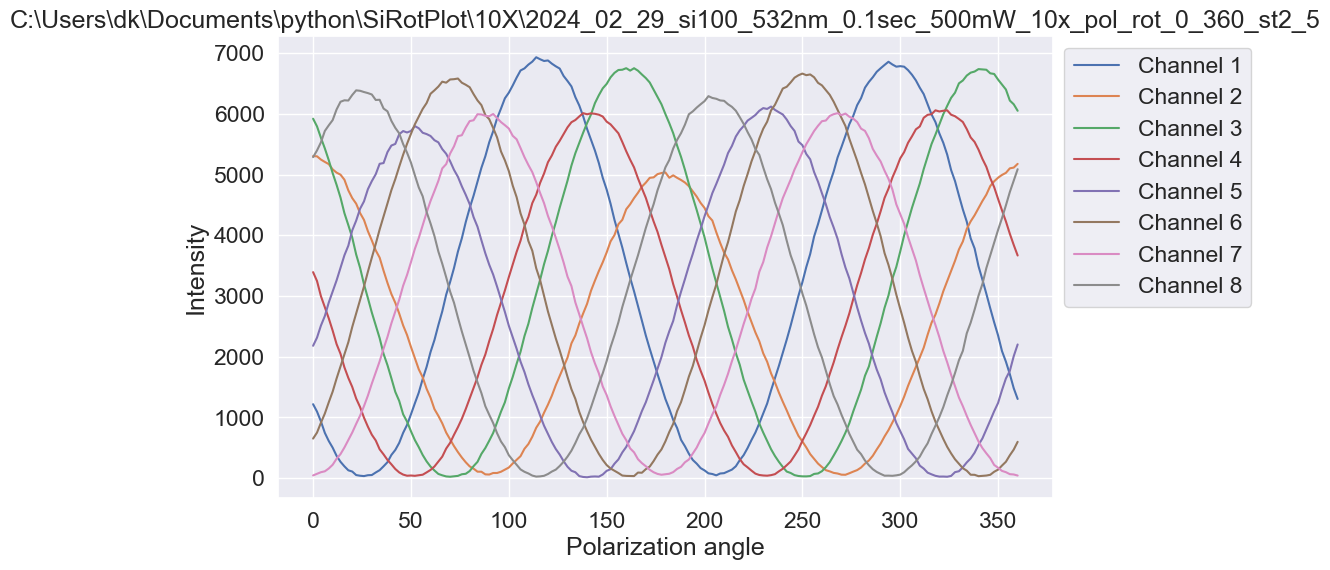

Plotting: C:\Users\dk\Documents\python\SiRotPlot\10X\2024_02_29_si110_532nm_0.05sec_250mW_10x_pol_rot_0_360_st2_5


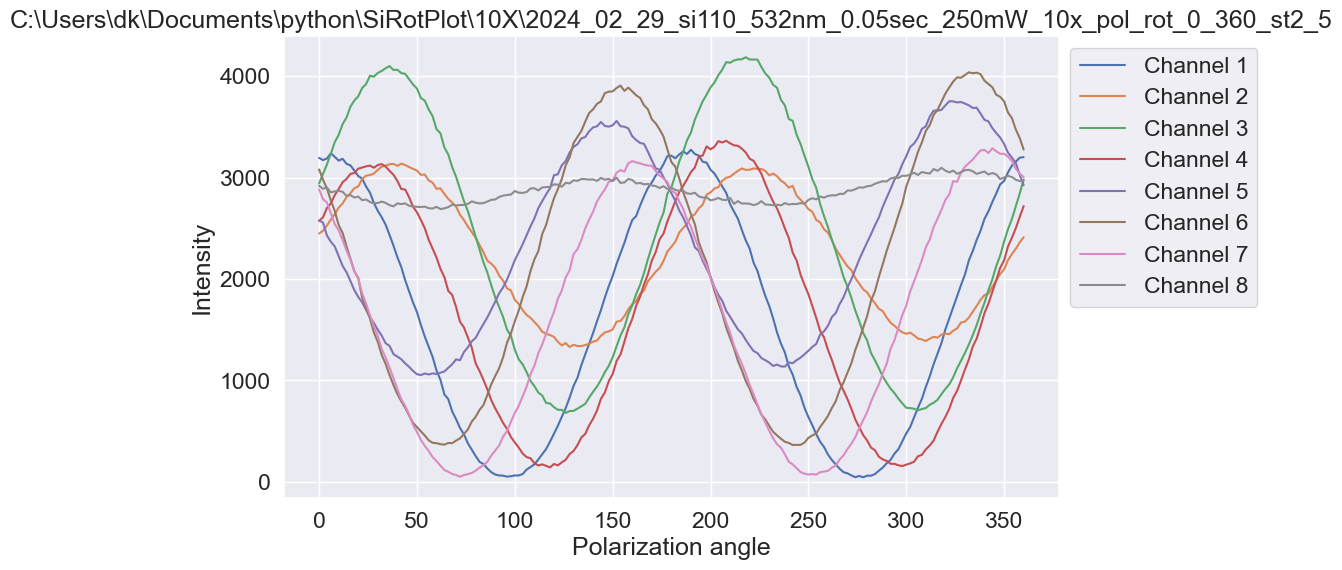

Plotting: C:\Users\dk\Documents\python\SiRotPlot\10X\2024_02_29_si111_532nm_0.1sec_500mW_10x_pol_rot_0_360_st2_5


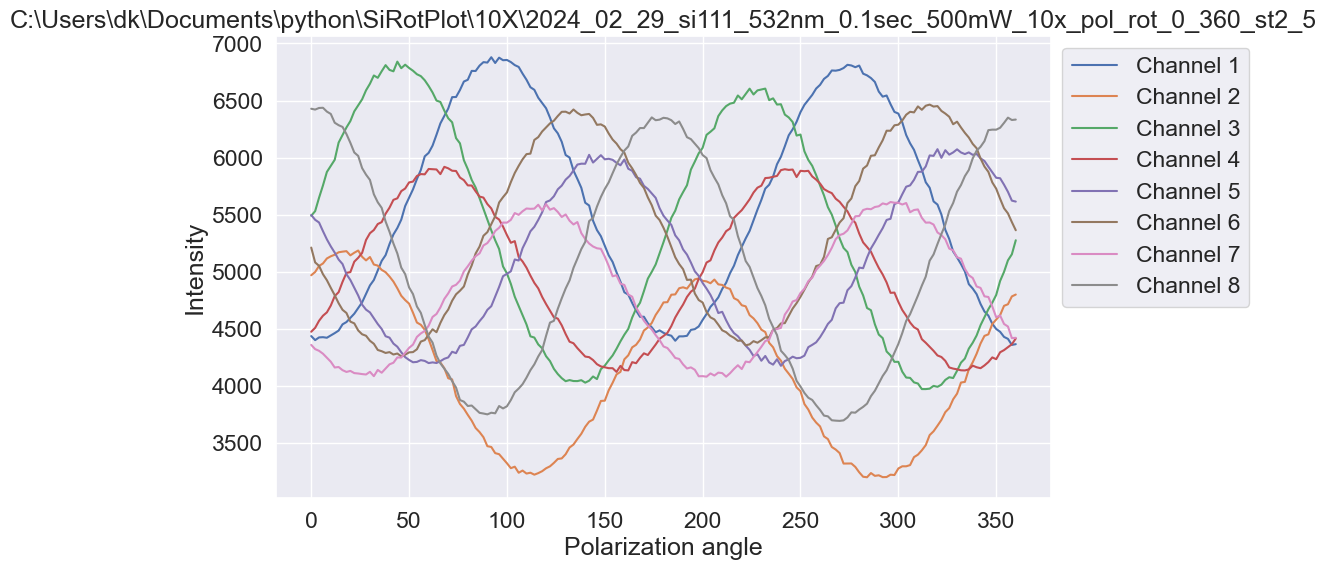

In [10]:
peak_files = [f for f in os.listdir(dir_path) if f.endswith('.peak')]
file_paths = [os.path.join(dir_path, f) for f in peak_files]
# Extract filenames without paths for display in the widget
file_names = [os.path.basename(f) for f in file_paths]
# Create a mapping from filenames to file paths to easily retrieve the full path
file_path_mapping = dict(zip(file_names, file_paths))

# Function to plot data from selected files
def data_preparation(file_path):
    #for file_path in selected_files:
        loader = RamanDataLoader(file_path)
        data_subset = loader.data.squeeze()[:, 1:9]  # Adjusted for consistency
        window_length, polyorder = 15, 6
        smoothed_data = savgol_filter(data_subset, window_length, polyorder, axis=0)
        x = loader.metadata['peakDimensions']['AxesCoords'][1]  # Ensure this is correctly accessed
        return data_subset,smoothed_data, x, os.path.splitext(file_path)[0]


# Function to plot data from selected files
def plot_selected_files(selected_files):
    for file_path in selected_files:
        plt.figure(figsize=(10, 6))
        # Make sure data_preparation uses the file_path to load data
        data_subset,smoothed_data, x, filename_without_extension = data_preparation(file_path)        
        # Debugging print to ensure the correct file is processed
        print(f"Plotting: {filename_without_extension}")

        for i in range(data_subset.shape[1]):
            plt.plot(x, data_subset[:, i], label=f'Channel {i+1}')
        plt.xlabel('Polarization angle')
        plt.ylabel('Intensity')
        plt.title(filename_without_extension)
        plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
        plt.savefig(f'{filename_without_extension}.png', dpi=300, bbox_inches='tight')
        plt.show()
        plt.close()# List all .peak files in the folder
        
        

# Create a widget for selecting files to plot
select_widget = widgets.SelectMultiple(
    options=file_names,  # Use filenames without paths
    value=[file_names[0]],  # Default value, adjust as necessary
    description='Files',
    disabled=False,
    layout=widgets.Layout(width='800px', height='200px')  # Adjust width and height as needed
)

# Button to trigger plotting of selected files

plot_selected_button = widgets.Button(description="Plot Selected Files")
plot_all_button = widgets.Button(description="Plot All")

def on_plot_selected_button_clicked(b):
    selected_file_names = select_widget.value
    selected_files = [file_path_mapping[name] for name in selected_file_names]
    plot_selected_files(selected_files)

def on_plot_all_button_clicked(b):
    plot_selected_files(file_paths)

plot_selected_button.on_click(on_plot_selected_button_clicked)
plot_all_button.on_click(on_plot_all_button_clicked)

display(select_widget, plot_selected_button, plot_all_button)